# Introduction

Many people play games. These games could be something like an adventure game, an action game or just a simple puzzle game. Everyone has their own taste in what games they like, but pretty much everyone agrees that the game that they want to play has to be good and fun to play. For this reason game reviews exist. Game reviews are a way for the consumer to read up about a certain game they want to play and see if the game will be worth their time or not. These reviews usually go together with a numerical rating from 1 to 10 to show how good the game is, with 1 being the worst rating and 10 being the best.

But what influences this rating? What factors affect the kind of rating a game gets? In this Notebook I will predict the rating of games.

In order to predict the rating I will use game, review and release data collected from the [Gamespot API](https://www.gamespot.com/api/documentation#toc-0-0). Gamespot is a game review website that makes reviews done by professional game reviewers.

# Data collection

Before we can do any form of analysis we have to collect our data first and install the necessary libraries. So let's do that first!

These are the libraries that I will make use of in this Notebook.

In [24]:
import pandas as pd
import requests
import json
from datetime import datetime as dt
from functools import reduce
import statistics as st
import seaborn as sb
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

To make use of the Gamespot API I have to define a personal User-Agent so that any request I make will not be blocked. I have chosen the name DataLearning, but it can be whatever name you want it to be. Furthermore I have to acquire an API token to be able to use the API. 

The API token has been purposefully omitted from view. You'll have to put in your own token if you want to make use of this notebook. You can request an API token here [Grab an API key](https://www.gamespot.com/api/)

In [2]:
# Create a unique User-Agent so that the API-calls aren't blocked
headers = {"User-Agent" : "DataLearning"}

# The token that is required for the API
api_key = "OMITTED" #The API key is not visible for security reasons.

In order to get the data that I want I have to set up three urls that will be used to make requests and collect data. These urls will be used to gather game data, review data and release data.

In [3]:
# Set up API call for games
url_games = "http://www.gamespot.com/api/games/"
# Set up API call for reviews
url_reviews = "http://www.gamespot.com/api/reviews/"
# Set up API call for releases
url_releases = "http://www.gamespot.com/api/releases/"

In order to get the data in the desired format I have to setup some parameters. The API allowed me to setup a field_list in which I could declare which fields I wanted to collect as to reduce the response time. I wanted to make use of this so that I would only have the fields that I found interesting. Sadly when setting up a field_list for the game data and release data it didn't work as intended so I had to select all the possible fields. The review data field_list worked perfectly fine however so I was able to select the fields I needed.

In [4]:
# Set paremeters to give the API-calls
parameters = {
        "api_key" : api_key,
        "offset" : 0,
        "limit" : 100,
        "format" : "json"
    } 

# Set specific parameters for the reviews api
parameters_reviews = {
        "api_key" : api_key,
        "field_list" : "title,score",
        "offset" : 0,
        "limit" : 100,
        "format" : "json"
    }

Now that the urls and parameters have been setup I can collect the data I want. In order to collect more than 100 results I have created a loop that increases the offset by 100 each time after a request has been made. The reason I'm increasing the offset each time is because it allows me to get new data every time I do a request. If I do not increase the offset I would just get the same data each time I do a request, and that is not someting I want to happen.

I'm collecting a lot of data by doing multiple requests on three different API's so running this loop can take quite some time.

In [40]:
games = pd.DataFrame()
releases = pd.DataFrame()
reviews = pd.Dataframe()

# Loop to increment the offset in order to get more than 100 results
for i in range(1000):
    response_games = requests.get(url_games, params=parameters, headers=headers)
    response_releases = requests.get(url_releases, params=parameters, headers=headers)
    response_reviews = requests.get(url_reviews, params=parameters_reviews, headers=headers)
    
    api_data_games = json.loads(response_games.content)
    api_data_releases = json.loads(response_releases.content)
    api_data_reviews = json.loads(response_reviews.content)

    games = games.append(api_data_games["results"])
    releases = releases.append(api_data_releases["results"])
    reviews = reviews.append(api_data_reviews["results"])
    
    parameters["offset"] += 100
    parameters_reviews["offset"] += 100
    
# Resets the index to avoid duplicate indexes 
games = games.reset_index(drop=True)
releases = releases.reset_index(drop=True)
reviews = reviews.reset_index(drop=True)

Now that I have the data, Let's write it to a csv. I'm doing this because then I won't have to rely on the API anymore to get my data and won't have to run it again and wait long times for the data to be available. Also I find it better to store the collected data in a csv because if the API is unavailabe for some reason I would still have a dataset to work with.

In [41]:
# Write the data to csv
games.to_csv("gamespot_games.csv", index=False)
releases.to_csv("gamespot_releases.csv", index=False)
reviews.to_csv("gamespot_reviews.csv", index=False)

# Data merging and cleaning

Now that we have collected the data, let's prepare it for analysis by merging, inspecting and cleaning the data.

Let's see what data we have.

In [3]:
gamespot_games = pd.read_csv("gamespot_games.csv")

In [4]:
gamespot_games.head()

,release_date,description,id,name,deck,image,genres,themes,franchises,images_api_url,reviews_api_url,articles_api_url,videos_api_url,releases_api_url,site_detail_url
0,1995-09-26 12:00:00,Welcome to the New World Order. A gritty high ...,1,Command & Conquer,Overall Command & Conquer is a great strategy ...,{'square_tiny': 'https://www.gamespot.com/a/up...,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],https://www.gamespot.com/api/images/?filter=as...,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/releases/?filter=...,https://www.gamespot.com/command-and-conquer/
1,1996-03-31 12:00:00,NaN,2,Return of Arcade,"For nostalgia buffs, these old games are worth...",{'square_tiny': 'https://www.gamespot.com/a/up...,[{'name': 'Compilation'}],[],[{'name': 'Microsoft Arcade'}],https://www.gamespot.com/api/images/?filter=as...,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/releases/?filter=...,https://www.gamespot.com/return-of-arcade/
2,1995-11-30 12:00:00,From the combined talents of LucasArts and leg...,3,The Dig,"In almost every sense, The Dig represents a le...",{'square_tiny': 'https://www.gamespot.com/a/up...,[{'name': 'Adventure'}],[],[],https://www.gamespot.com/api/images/?filter=as...,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/releases/?filter=...,https://www.gamespot.com/the-dig/
3,1995-11-30 12:00:00,NaN,4,Mission Critical,"Put simply, Mission Critical was one of the be...",{'square_tiny': 'https://www.gamespot.com/a/up...,[{'name': 'Adventure'}],[],[],https://www.gamespot.com/api/images/?filter=as...,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/releases/?filter=...,https://www.gamespot.com/mission-critical/
4,1996-06-30 12:00:00,NaN,5,Links LS: Legends in Sports 1997 Edition,"With this update, Links LS can rightfully recl...",{'original': 'https://www.gamespot.com/a/uploa...,"[{'name': 'Golf'}, {'name': 'Simulation'}, {'n...",[],[{'name': 'Links Golf'}],https://www.gamespot.com/api/images/?filter=as...,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/releases/?filter=...,https://www.gamespot.com/links-ls-legends-in-s...


In [5]:
gamespot_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   release_date      20000 non-null  object
 1   description       10986 non-null  object
 2   id                20000 non-null  int64 
 3   name              20000 non-null  object
 4   deck              7371 non-null   object
 5   image             20000 non-null  object
 6   genres            20000 non-null  object
 7   themes            20000 non-null  object
 8   franchises        20000 non-null  object
 9   images_api_url    20000 non-null  object
 10  reviews_api_url   20000 non-null  object
 11  articles_api_url  20000 non-null  object
 12  videos_api_url    20000 non-null  object
 13  releases_api_url  20000 non-null  object
 14  site_detail_url   20000 non-null  object
dtypes: int64(1), object(14)
memory usage: 2.3+ MB


In [9]:
gamespot_releases = pd.read_csv("gamespot_releases.csv")

In [10]:
gamespot_releases.head()

,upc,release_date,distribution_type,id,name,region,rating,platform,game_api_url,reviews_api_url,articles_api_url,videos_api_url,images_api_url,association,publishers,developers
0,5028587080975.0,1996-12-31 12:00:00,Retail,1,Command & Conquer,Europe,"{'name': 'PEGI: 16+', 'descriptors': 'Violence'}",PlayStation,https://www.gamespot.com/api/games/?filter=id%3A1,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/images/?filter=as...,5000-1,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
1,4992713021846.0,1998-04-16 12:00:00,Retail,2,Command & Conquer Complete,Japan,NaN,PlayStation,https://www.gamespot.com/api/games/?filter=id%3A1,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/images/?filter=as...,5000-1,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
2,52145880269.0,1997-02-28 12:00:00,Retail,3,Command & Conquer,North America,"{'name': 'ESRB: T', 'descriptors': 'Violence'}",PlayStation,https://www.gamespot.com/api/games/?filter=id%3A1,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/images/?filter=as...,5000-1,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
3,5028587081392.0,1998-12-31 12:00:00,Retail,4,Command & Conquer (Platinum),Europe,"{'name': 'PEGI: 16+', 'descriptors': 'Violence'}",PlayStation,https://www.gamespot.com/api/games/?filter=id%3A1,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/images/?filter=as...,5000-1,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
4,NaN,2009-11-25 12:00:00,PSOne Classics,5,Command & Conquer,North America,"{'name': 'ESRB: T', 'descriptors': 'Violence'}",PlayStation,https://www.gamespot.com/api/games/?filter=id%3A1,https://www.gamespot.com/api/reviews/?filter=a...,https://www.gamespot.com/api/articles/?filter=...,https://www.gamespot.com/api/videos/?filter=as...,https://www.gamespot.com/api/images/?filter=as...,5000-1,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."


In [11]:
gamespot_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   upc                36944 non-null   object
 1   release_date       100000 non-null  object
 2   distribution_type  100000 non-null  object
 3   id                 100000 non-null  int64 
 4   name               100000 non-null  object
 5   region             100000 non-null  object
 6   rating             42024 non-null   object
 7   platform           100000 non-null  object
 8   game_api_url       100000 non-null  object
 9   reviews_api_url    100000 non-null  object
 10  articles_api_url   100000 non-null  object
 11  videos_api_url     100000 non-null  object
 12  images_api_url     100000 non-null  object
 13  association        100000 non-null  object
 14  publishers         99495 non-null   object
 15  developers         96131 non-null   object
dtypes: int64(1), object(1

In [12]:
gamespot_reviews = pd.read_csv("gamespot_reviews.csv")

In [13]:
gamespot_reviews.head()

,title,score
0,Under a Killing Moon,6.9
1,Warcraft II: Tides of Darkness,9.3
2,Warhammer: Shadow of the Horned Rat,6.8
3,Whiplash,6.1
4,Wing Commander IV: The Price of Freedom,8.5


I can see that there is a lot of interesting data present that can be used in my analysis and prediction. However some of this data is presented in an unusual way and will have to be cleaned before it can be used. I'm also seeing values which could be interpreted as NaN values albeit shown in an unusual way. These would have to be cleaned as well. I also see columns that do not contain any useful information. I'll have to remove these columns.

First let's make sure we only have the columns we want to use from each dataset. The dataset gamespot_reviews has the value score which I want to predict. Since it's the only column apart from the title column, I do not need to clean anything within that dataset. But for the datasets gamespot_games and gamespot_releases I'll have to create a subset that only contains the columns I potentially want to use as a predicting variable.

For dataset gamespot_games these columns are: name, genres, themes, franchises and release_date.

In [8]:
gamespot_games_sub = gamespot_games[["name", "genres", "themes", "franchises", "release_date"]].copy()

gamespot_games_sub.head()

,name,genres,themes,franchises,release_date
0,Command & Conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00
1,Return of Arcade,[{'name': 'Compilation'}],[],[{'name': 'Microsoft Arcade'}],1996-03-31 12:00:00
2,The Dig,[{'name': 'Adventure'}],[],[],1995-11-30 12:00:00
3,Mission Critical,[{'name': 'Adventure'}],[],[],1995-11-30 12:00:00
4,Links LS: Legends in Sports 1997 Edition,"[{'name': 'Golf'}, {'name': 'Simulation'}, {'n...",[],[{'name': 'Links Golf'}],1996-06-30 12:00:00


I decided on these columns because I think they could have the most impact on the rating a game receives. Take genres for example. A game with genre action might be rated higher than a game with genre adventure simply because people like games of the genre action more than games with genre adventure. The same could be said for themes. Maybe people rate games with a sci-fi theme higher than a game with another theme because they like sci-fi games more.

For the franchises I think it can influence the rating due to how much people like a certain franchise. If a franchise is well liked people might rate their games higher because they like said franchise. The opposite could apply just as much. If a franchise is not well liked people might rate a game lower simply because they don't like the franchise.

Regarding the release date I think there can be multiple reasons on why this can impact the rating of a game. Either people are more lenient or more critical during a certain release year, or the games are better/worse that year. It could very well be both.

For dataset gamespot_releases the columns I want to use are: name, region, platform, publishers and developers.

In [9]:
gamespot_releases_sub = gamespot_releases[["name", "region", "platform", "publishers", "developers"]].copy()

gamespot_releases_sub.head()

,name,region,platform,publishers,developers
0,Command & Conquer,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
1,Command & Conquer Complete,Japan,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
2,Command & Conquer,North America,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
3,Command & Conquer (Platinum),Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."
4,Command & Conquer,North America,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki..."


I want to use region because I think that people in different regions might rate games differently. Maybe people in Europe rate games more leniently and thus higher compared to people in Japan, who might rate games more critically and are therfore lower in rating.

Platform might also be an interesting factor in what impacts the rating. Maybe people prefer games on a certain platform and tend to rate those games higher. Or maybe it could be that a game released on PC is rated higher due to the game being better implemented on that platform compared to the game's release on a different platform like Playstation.

For the publishers and developers I think it can impact the rating because of the reputation the publishers and developers have and whether they release good games or not. If a publisher/developer has a good reputation and releases good games, people will most likely rate those games higher than when a publisher or developer has a bad reputation and releases bad games.

Now that I've decided which columns to use, we can start merging the data into one dataset. I will merge the dataset on name. To do this I first have to change the column name of gamespot_reviews because otherwise I won't be able to merge it with the other datasets. Then I will convert all the names to lowercase characters to prevent loss of data due to a name having capitalization where a name in another dataset does not.

In [10]:
gamespot_reviews = gamespot_reviews.rename(columns={"title": "name"})

gamespot_games_sub["name"] = gamespot_games["name"].str.lower()
gamespot_releases_sub["name"] = gamespot_releases["name"].str.lower()
gamespot_reviews["name"] = gamespot_reviews["name"].str.lower()

In [11]:
gamespot_dfs = [gamespot_games_sub, gamespot_releases_sub, gamespot_reviews]

gamespot_merged = reduce(lambda  left,right: pd.merge(left,right,on=['name']), gamespot_dfs)

Now that the data has been merged let's see how many rows we have.

In [12]:
gamespot_merged

,name,genres,themes,franchises,release_date,region,platform,publishers,developers,score
0,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
1,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.2
2,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",8.2
3,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",7.6
4,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,North America,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
...,...,...,...,...,...,...,...,...,...,...
18011,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Japan,NES,"[{'name': 'Nintendo'}, {'name': 'Hamster'}]","[{'name': 'Nintendo'}, {'name': 'Hamster'}]",2.2
18012,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Europe,Game Boy,"[{'name': 'GameTek'}, {'name': 'Coconuts Japan...","[{'name': 'Denton Designs'}, {'name': 'Rage So...",2.2
18013,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,North America,Arcadia 2001,"[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...","[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...",2.2
18014,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Europe,Atari 8-bit,"[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...","[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...",2.2


After merging all the data we are left with 18016 rows of data. This sounds pretty good but at a glance I can already see that games are present multiple times in my dataset. This could be because a game can be released in multiple regions and on multiple platforms. I also see that there are slight differences in the rating each time a game reoccurs. Maybe a review gets updated after some time. To resolve this issue I would have to check for duplicate data and remove them from the dataset.

But I can't just remove duplicates based on name. As I said a game could be released on multiple platforms and in multiple regions. Considering the differences in rating per reoccurence of a game, this difference could also very well be because of a game getting a separate review per platorm, per region instead of it only being an updated review. If I were to remove duplicate rows based on name it could potentially weaken the impact of these two factors in my predictive model.

But what I also see is that a game is released on the same platform multiple times within a region. I find it very unlikely that the same game would be released multiple times on the same platform. Because of this I decided to drop rows based on name and if a game has multiple releases on the same platform in the same region.

In [13]:
gamespot_merged = gamespot_merged.drop_duplicates(subset=["name", "region", "platform"])
gamespot_merged = gamespot_merged.reset_index(drop=True)

Now that we removed duplicate rows let's see how much has remained.

In [14]:
gamespot_merged

,name,genres,themes,franchises,release_date,region,platform,publishers,developers,score
0,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
1,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,North America,PlayStation,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
2,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,North America,PC,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
3,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,Europe,PC,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
4,command & conquer,"[{'name': 'Real-Time'}, {'name': 'Strategy'}]",[{'name': 'Sci-Fi'}],[{'name': 'Command & Conquer'}],1995-09-26 12:00:00,North America,Nintendo 64,"[{'name': 'Westwood Studios'}, {'name': 'Ninte...","[{'name': 'Westwood Studios'}, {'name': 'Looki...",9.3
...,...,...,...,...,...,...,...,...,...,...
9088,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Australia,NES,"[{'name': 'Nintendo'}, {'name': 'Hamster'}]","[{'name': 'Nintendo'}, {'name': 'Hamster'}]",2.2
9089,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Europe,Game Boy,"[{'name': 'GameTek'}, {'name': 'Coconuts Japan...","[{'name': 'Denton Designs'}, {'name': 'Rage So...",2.2
9090,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,North America,Arcadia 2001,"[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...","[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...",2.2
9091,soccer,"[{'name': 'Arcade'}, {'name': 'Soccer'}, {'nam...",[],[],1982-12-31 12:00:00,Europe,Atari 8-bit,"[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...","[{'name': 'Emerson Radio Corp.'}, {'name': 'Th...",2.2


From the 18016 rows we had before removing the duplicate rows, only 9093 rows remain. Even though a lot of rows were removed we still have quite a lot to work with. However the data cleaning process is not done so I will probably lose some more. Let's take another look at the columns we have to gain some insight in how the data is presented.

From what I can see the column values of genres, themes and franchises, publishers and developers look a bit unusual. Let's take a look at what kind of values the columns have, and how often they occur in the dataset. If a column contains values that pretty much occur only once, it might be better to leave them out of the predictive model. In order to get a good look at these values I'll have to adjust the maximum amount of rows shown.

In [34]:
pd.set_option("display.max_rows", None)

Now that we have set a maximum view of rows, let's take a look at the genres

In [72]:
gamespot_merged["genres"].value_counts()

[{'name': 'Action'}, {'name': 'Adventure'}]                                                                    631
[{'name': 'Arcade'}, {'name': 'Driving/Racing'}]                                                               603
[{'name': '3D'}, {'name': 'Action'}, {'name': 'First-Person'}, {'name': 'Shooter'}]                            456
[{'name': 'Role-Playing'}]                                                                                     377
[{'name': 'Simulation'}]                                                                                       334
[{'name': 'Real-Time'}, {'name': 'Strategy'}]                                                                  326
[{'name': '3D'}, {'name': 'Action'}, {'name': 'Platformer'}]                                                   323
[{'name': '2D'}, {'name': 'Action'}, {'name': 'Platformer'}]                                                   309
[{'name': 'Driving/Racing'}, {'name': 'Simulation'}]                            

From what I can see is that there are a lot of genres that exist. Apparently according to this dataset it is possible for a game to have multiple genres associated to them. For my prediction however I will assume that a game only has one genre.

This means I'll have to decide what kind of genres I find most interesting and useful to use in my analysis and prediction.

The genres that I will use are:

Music/Rhythm, Puzzle, Sports, Fighting, Platformer, Strategy, Simulaton, Role-Playing, Shooter, Arcade, Adventure, Action

I've decided on these genres because they by far occur the most in the dataset. Besides that most genres that were there are way too specific of a genre meaning they were present only a couple of times. Luckily most of them can be merged with one of the genres I decided to use. For example a game with the genre "Hockey" can easily be merged with the genre "Sports".

let's take  a look at themes

In [73]:
gamespot_merged["themes"].value_counts()

[]                                              6606
[{'name': 'Sci-Fi'}]                             773
[{'name': 'Modern'}]                             603
[{'name': 'Fantasy'}]                            458
[{'name': 'Historic'}]                           228
[{'name': 'Horror'}]                             171
[{'name': 'Military'}, {'name': 'Modern'}]        72
[{'name': 'Sci-Fi'}, {'name': 'Space'}]           67
[{'name': 'Historic'}, {'name': 'Military'}]      51
[{'name': 'Military'}]                            36
[{'name': 'Game Show'}]                           17
[{'name': 'VR'}]                                   7
[{'name': 'Sci-Fi'}, {'name': 'VR'}]               4
Name: themes, dtype: int64

I can immediately see that most of the games we have do not have a theme associated to them. This means it might not be worthwhile to take themes into consideration when performing my prediction. If I am going to use themes in my prediction this would mean I'll lose a considerable amount of data and I'd rather not have that happen.

However I can perform a prediction where one includes the themes, and one that does not include the themes. This way I won't have to worry about losing data. Sure the prediction that includes the themes will have less data to work with, but I still think it's better to do that than to decide to not use the themes at all.

With that in mind I will use the following themes in my prediction:

VR, Game Show, Military, Horror, Historic, Fantasy, Modern and Sci-Fi

I decided not to include Space because I find it too specific of a theme and it does not occur a lot in the dataset. It's better to merge it with the theme Sci-Fi instead.

Let's take a look at franchises

In [44]:
gamespot_merged["franchises"].value_counts().head(25)

[]                                                            2345
[{'name': 'Final Fantasy'}]                                     94
[{'name': 'Sonic the Hedgehog'}]                                79
[{'name': 'NBA Live'}]                                          60
[{'name': 'FIFA Soccer'}]                                       57
[{'name': 'Star Trek'}]                                         52
[{'name': 'Double Dragon'}, {'name': 'Arcade Archives'}]        52
[{'name': 'Frogger'}]                                           48
[{'name': 'Worms'}]                                             47
[{'name': 'NHL Hockey'}]                                        46
[{'name': 'Pac-Man'}, {'name': 'Arcade Game Series'}]           46
[{'name': 'DOOM'}]                                              46
[{'name': 'Madden Football'}]                                   43
[{'name': 'WWE / WWF'}]                                         42
[{'name': 'Tomb Raider'}]                                     

Not all games seem to have a franchise associated to them. Furthermore I see that besides a couple of franchises most franchises occur only a handful of times and there are a lot of franchises. This means that using franchises in my prediction would probably be not very useful. I expect it to not yield any significant results and will leave franchises out of my predictions.

Disclaimer: For better readability I only show the first 25 results.

Let's take a look at publishers

In [46]:
gamespot_merged["publishers"].value_counts().head(25)

[{'name': 'Konami'}]                                                                                                                                                                                                                                                                                                         203
[{'name': 'Nintendo'}]                                                                                                                                                                                                                                                                                                       178
[{'name': 'Sega'}]                                                                                                                                                                                                                                                                                                           140
[{'name': 'Ubisoft'}]                

There are a lot of publishers present in this dataset and I mean a lot. So many in fact that it is very hard to see how many publishers there really are. If I were to make a list of what publishers to include in my prediction I will most certainly lose data. If I want to include every possible publisher it would take too much time to figure out what publishers there are.

Therefore I decided to include only the most well known publishers. These publishers are:

Konami, Nintendo, Sega, Ubisoft, Acclaim, Midway, THQ, Electronic Arts, Capcom, Activision, and Square Enix.

I am bound to lose data like this but as with the themes I can just do another prediction that does not include the publishers.

Disclaimer: For better readability I only show the first 25 results.

Let's take a look at developers

In [48]:
gamespot_merged["developers"].value_counts().head(25)

[{'name': 'Capcom'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                      129
[{'name': 'Nintendo'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                     74
[{'name': 'Namco'}]                         

Like with the publishers there are many developers present in this dataset. Of which many that are the same as the publishers. This would make predicting rating based on both of these values redundant since they are the same. From the developers that are not the same as the publisher they only occur a handful of times making me think that using the developers as a predictor might not be very useful. I will leave the developers out of my prediction.

Disclaimer: For better readability I only show the first 25 results.

Now that i've looked at the genres, themes, franchises, publishers and developers it's time to clean that data and remove columns where necessary. But first let's set the maxmimum viewed rows back to the default value to ensure less clutter. Also to prevent data loss and potential data type conflicts I will convert all the columns that are not numerical to strings, and convert them to lowercase just to be safe. I'll also convert release_date to an actual datetime showing only the year of release since that's the only important part of the release_date column we need.

In [40]:
pd.reset_option("display.max_rows")

In [15]:
gamespot_merged["genres"] = gamespot_merged["genres"].str.lower()
gamespot_merged["themes"] = gamespot_merged["themes"].str.lower()
gamespot_merged["publishers"] = gamespot_merged["publishers"].str.lower()

for i in gamespot_merged.index:
    gamespot_merged.iloc[i, 4] = dt.strptime(gamespot_merged.iloc[i, 4], "%Y-%m-%d %H:%M:%S").year

gamespot_merged[["genres", "themes", "region", "platform", "publishers"]] = gamespot_merged[["genres", "themes", "region", "platform", "publishers"]].astype(str)

With the column data types in order and having converted the string values to lowercase, I will create a dataframe where the cleaned data will be stored into.

In [35]:
gamespot_final = gamespot_merged[["name", "score", "release_date", "region", "platform"]].copy()
gamespot_final[["genres", "themes", "publishers"]] = ""

gamespot_final

,name,score,release_date,region,platform,genres,themes,publishers
0,command & conquer,9.3,1995,Europe,PlayStation,,,
1,command & conquer,9.3,1995,North America,PlayStation,,,
2,command & conquer,9.3,1995,North America,PC,,,
3,command & conquer,9.3,1995,Europe,PC,,,
4,command & conquer,9.3,1995,North America,Nintendo 64,,,
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,,,
9089,soccer,2.2,1982,Europe,Game Boy,,,
9090,soccer,2.2,1982,North America,Arcadia 2001,,,
9091,soccer,2.2,1982,Europe,Atari 8-bit,,,


In order to clean the data I will create a loop that extracts the data, cleans it and puts it into the new dataframe.

In [36]:
name = ""

for i in gamespot_final.index:
    
    # Check to see if a game has already been processed
    if(gamespot_final.iloc[i, 0] != name):
        name = gamespot_final.iloc[i, 0]
        
        # Extract the genre from the gamespot_merged dataset and assign it to the associated game
        if("'music/rhythm'" != None and "'music/rhythm'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "music/rhythm"
        elif("'puzzle'" != None and "'puzzle'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "puzzle"
        elif("'sports'" != None and "'sports'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "sports"
        elif("'fighting'" != None and "'fighting'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "fighting"
        elif("'platformer'" != None and "'platformer'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "platformer"
        elif("'strategy'" != None and "'strategy'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "strategy"
        elif("'simulation'" != None and "'simulation'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "simulation"
        elif("'role-playing'" != None and "'role-playing'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "role-playing"
        elif("'shooter'" != None and "'shooter'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "shooter"
        elif("'arcade'" != None and "'arcade'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "arcade"
        elif("'adventure'" != None and "'adventure'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "adventure"
        elif("'action'" != None and "'action'" in gamespot_merged.iloc[i, 1]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "genres"] = "action"
    
        # Extract the theme from the gamespot_merged dataset and assign it to the associated game
        if("'vr'" != None and "'vr'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "vr"
        elif("'game show'" != None and "'game show'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "game show"
        elif("'military'" != None and "'military'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "military"
        elif("'horror'" != None and "'horror'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "horror"
        elif("'historic'" != None and "'historic'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "historic"
        elif("'fantasy'" != None and "'fantasy'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "fantasy"
        elif("'modern'" != None and "'modern'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "modern"
        elif("'sci-fi'" != None and "'sci-fi'" in gamespot_merged.iloc[i, 2]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "themes"] = "sci-fi"
            
        # Extract the publisher from the gamespot_merged dataset and assign it to the associated game
        if("'konami'" != None and "'konami'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "konami"
        elif("'nintendo'" != None and "'nintendo'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "nintendo"
        elif("'sega'" != None and "'sega'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "sega"
        elif("'ubisoft'" != None and "'ubisoft'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "ubisoft"
        elif("'acclaim'" != None and "'acclaim'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "acclaim"
        elif("'midway'" != None and "'midway'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "midway"
        elif("'thq'" != None and "'thq'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "thq"
        elif("'electronic arts'" != None and "'electronic arts'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "electronic arts"
        elif("'capcom'" != None and "'capcom'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "capcom"
        elif("'activision'" != None and "'activision'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "activision"
        elif("'square enix'" != None and "'square enix'" in gamespot_merged.iloc[i, 7]):
            gamespot_final.loc[gamespot_final["name"] == gamespot_merged.iloc[i, 0], "publishers"] = "square enix"

Let's check if the loop did it's job.

In [37]:
gamespot_final

,name,score,release_date,region,platform,genres,themes,publishers
0,command & conquer,9.3,1995,Europe,PlayStation,strategy,sci-fi,nintendo
1,command & conquer,9.3,1995,North America,PlayStation,strategy,sci-fi,nintendo
2,command & conquer,9.3,1995,North America,PC,strategy,sci-fi,nintendo
3,command & conquer,9.3,1995,Europe,PC,strategy,sci-fi,nintendo
4,command & conquer,9.3,1995,North America,Nintendo 64,strategy,sci-fi,nintendo
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,sports,,
9089,soccer,2.2,1982,Europe,Game Boy,sports,,
9090,soccer,2.2,1982,North America,Arcadia 2001,sports,,
9091,soccer,2.2,1982,Europe,Atari 8-bit,sports,,


Looks like it did the job. Every game now has it's genre, theme and publisher presented in a clear way that can be used in the analysis and the prediction. I'll save it to a csv so that the data is save and we won't have to run that loop again.

In [194]:
gamespot_final.to_csv("gamespot_final.csv", index=False)

In [3]:
gamespot_final = pd.read_csv("gamespot_final.csv")

gamespot_final

,name,score,release_date,region,platform,genres,themes,publishers
0,command & conquer,9.3,1995,Europe,PlayStation,strategy,sci-fi,nintendo
1,command & conquer,9.3,1995,North America,PlayStation,strategy,sci-fi,nintendo
2,command & conquer,9.3,1995,North America,PC,strategy,sci-fi,nintendo
3,command & conquer,9.3,1995,Europe,PC,strategy,sci-fi,nintendo
4,command & conquer,9.3,1995,North America,Nintendo 64,strategy,sci-fi,nintendo
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,sports,NaN,NaN
9089,soccer,2.2,1982,Europe,Game Boy,sports,NaN,NaN
9090,soccer,2.2,1982,North America,Arcadia 2001,sports,NaN,NaN
9091,soccer,2.2,1982,Europe,Atari 8-bit,sports,NaN,NaN


I think we are almost done with fully cleaning the data. The only thing that I have to do still is look at the values and remove any form of data that doesn't seem right to have in the dataset. Let's start with checking for NaN values.

In [102]:
gamespot_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          9093 non-null   object 
 1   score         9093 non-null   float64
 2   release_date  9093 non-null   int64  
 3   region        9093 non-null   object 
 4   platform      9093 non-null   object 
 5   genres        8664 non-null   object 
 6   themes        2487 non-null   object 
 7   publishers    4796 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 568.4+ KB


Looks like there are quite a few NaN values present in the columns genres, themes and publishers. These will have to be removed when I do a prediction containing all of these variables. But since I'm planning to do multiple predictions that might not use those columns I will not remove them just yet.

Now that I checked for NaN values let's check the values in release_date.

In [103]:
gamespot_final["release_date"].describe()

count    9093.000000
mean     1999.558122
std         6.660259
min      1977.000000
25%      1997.000000
50%      1999.000000
75%      2004.000000
max      2099.000000
Name: release_date, dtype: float64

From what I can see here everything seems to look fine except for the max value. Apparently there are games that have been released in 2099. Seeing as this is only the max value it could very well be that there are more games with a release date in the future. This is of course not possible since that year has not occured yet and these values should be removed from the dataset. I will make sure that only games with a release date of 2022 or lower are present in the dataset. 

In [104]:
gamespot_final = gamespot_final[gamespot_final["release_date"] <= 2022].copy()

Let's check the release date values again.

In [105]:
gamespot_final["release_date"].describe()

count    9078.000000
mean     1999.395351
std         5.326304
min      1977.000000
25%      1997.000000
50%      1999.000000
75%      2004.000000
max      2019.000000
Name: release_date, dtype: float64

That looks much better! Now the maximum is 2019 which is far more realistic. But where have the games from 2020 to 2022 go? The data I collected did not include anything past 2019 apart from these futuristic numbers.

In [106]:
gamespot_final["score"].describe()

count    9078.000000
mean        6.924620
std         1.653414
min         0.000000
25%         5.900000
50%         7.200000
75%         8.200000
max        10.000000
Name: score, dtype: float64

It looks like the minimum is a 0 but Gamespot the platform I got my data from reviews on a 1-10 scale as explained here [About GameSpot Reviews](https://www.gamespot.com/review-guidelines/#comments-block-30833071) This means that games with a rating of 0 should not be included in the dataset. They also say they don't do inceremental values but this does not reflect in the dataset I collected. Then again the article is 8 years old so things might have changed.

In [4]:
gamespot_final = gamespot_final[(gamespot_final["release_date"] <= 2022) & (gamespot_final["score"] != 0)]

In [108]:
gamespot_final["score"].describe()

count    9077.000000
mean        6.925383
std         1.651906
min         1.000000
25%         5.900000
50%         7.200000
75%         8.200000
max        10.000000
Name: score, dtype: float64

# Exploratory Data Analysis

With the dataset fully cleaned let's do some exploratory data analysis!

In [6]:
gamespot_final

,name,score,release_date,region,platform,genres,themes,publishers
0,command & conquer,9.3,1995,Europe,PlayStation,strategy,sci-fi,nintendo
1,command & conquer,9.3,1995,North America,PlayStation,strategy,sci-fi,nintendo
2,command & conquer,9.3,1995,North America,PC,strategy,sci-fi,nintendo
3,command & conquer,9.3,1995,Europe,PC,strategy,sci-fi,nintendo
4,command & conquer,9.3,1995,North America,Nintendo 64,strategy,sci-fi,nintendo
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,sports,NaN,NaN
9089,soccer,2.2,1982,Europe,Game Boy,sports,NaN,NaN
9090,soccer,2.2,1982,North America,Arcadia 2001,sports,NaN,NaN
9091,soccer,2.2,1982,Europe,Atari 8-bit,sports,NaN,NaN


I would like to see what the distribution is of score and if there are any outliers in the dataset.

(1.0, 10.0)

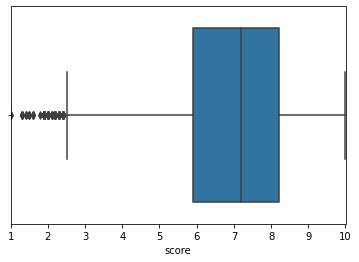

In [179]:
box_score = sb.boxplot(x="score", data=gamespot_final)
box_score.set_xlim(1, 10)

(1.0, 10.0)

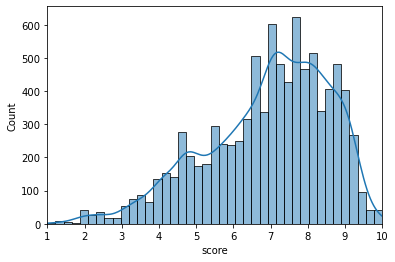

In [26]:
hist_score = sb.histplot(x="score", kde=True, data=gamespot_final)
hist_score.set_xlim(1, 10)

Most of the ratings lie between 6 and 8. Most of the ratings skew to the left. There also are a bunch of outliers present having a rating of 2 and below. I'll have to check that out.

In [115]:
gamespot_final[gamespot_final["score"] < 2.5]

,name,score,release_date,region,platform,genres,themes,publishers
380,slingo,1.5,1998,North America,PC,NaN,NaN,NaN
381,slingo,1.5,1998,North America,Dedicated Console,NaN,NaN,NaN
761,big rigs: over the road racing,1.0,2003,North America,PC,simulation,NaN,NaN
922,fbi hostage rescue,1.9,2004,North America,PC,shooter,modern,NaN
1176,armored moon: the next eden,2.2,1998,North America,PC,strategy,NaN,NaN
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,sports,NaN,NaN
9089,soccer,2.2,1982,Europe,Game Boy,sports,NaN,NaN
9090,soccer,2.2,1982,North America,Arcadia 2001,sports,NaN,NaN
9091,soccer,2.2,1982,Europe,Atari 8-bit,sports,NaN,NaN


There doesn't seem to be anything wrong with these ratings. From what I can see these are games that are bad and got a low rating because of that. They also aren't that far away from the non-outliers so the impact is probably negligible. I see no reason not to include them.

I would like to check release_date for any potential outliers and to show the overall distribution.

<AxesSubplot:xlabel='release_date'>

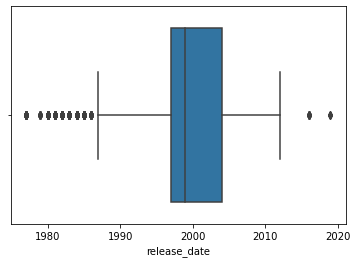

In [118]:
sb.boxplot(x="release_date", data=gamespot_final)

<AxesSubplot:xlabel='release_date', ylabel='Count'>

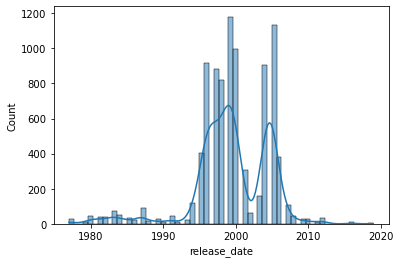

In [154]:
sb.histplot(x="release_date", kde=True, data=gamespot_final)

Most games are released around the year 2000 skewing mostly to the left. There are also a couple of outliers present with most of them before year 1990 and two after year 2010.

In [168]:
gamespot_final[gamespot_final["release_date"] < 1987]

,name,score,release_date,region,platform,genres,themes,publishers
360,asteroids,7.0,1979,North America,Atari 5200,shooter,NaN,NaN
361,asteroids,7.0,1979,North America,Atari 2600,shooter,NaN,NaN
362,asteroids,7.0,1979,Japan,Atari 2600,shooter,NaN,NaN
363,asteroids,7.0,1979,Europe,Atari 2600,shooter,NaN,NaN
364,asteroids,7.0,1979,North America,Atari 7800,shooter,NaN,NaN
...,...,...,...,...,...,...,...,...
9088,soccer,2.2,1982,Australia,NES,sports,NaN,NaN
9089,soccer,2.2,1982,Europe,Game Boy,sports,NaN,NaN
9090,soccer,2.2,1982,North America,Arcadia 2001,sports,NaN,NaN
9091,soccer,2.2,1982,Europe,Atari 8-bit,sports,NaN,NaN


In [141]:
gamespot_final[gamespot_final["release_date"] > 2013]

,name,score,release_date,region,platform,genres,themes,publishers
3541,the silver case,5.0,2016,North America,PC,adventure,NaN,NaN
3542,the silver case,5.0,2016,North America,PlayStation 4,adventure,NaN,NaN
3543,the silver case,5.0,2016,North America,Macintosh,adventure,NaN,NaN
3544,the silver case,5.0,2016,Europe,PlayStation 4,adventure,NaN,NaN
3545,the silver case,5.0,2016,Australia,PlayStation 4,adventure,NaN,NaN
3546,the silver case,5.0,2016,North America,Linux,adventure,NaN,NaN
3602,the witness,9.0,2016,Europe,Commodore 64,adventure,vr,NaN
3603,the witness,9.0,2016,North America,Apple II,adventure,vr,NaN
3604,the witness,9.0,2016,North America,PC,adventure,vr,NaN
3605,the witness,9.0,2016,North America,Tandy Color Computer,adventure,vr,NaN


From what I can see is that there is only one game released within those outlier years. Albeit released in multiple regions and on different platforms. I don't think this will impact the prediction by a lot since they aren't too far away from the non-outliers, so I won't remove them.

I would like to see the distribution between the ratings and the publisher to see if there is a potential bias.

(1.0, 10.0)

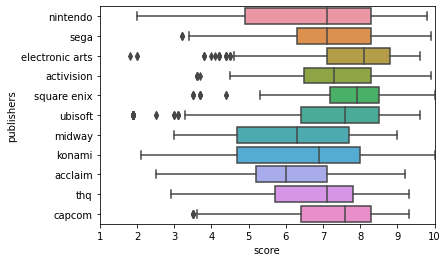

In [185]:
box_score_publishers = sb.boxplot(x="score", y="publishers", data=gamespot_final)
box_score_publishers.set_xlim(1, 10)

There does not seem to be a bias present since most publishers have a nice spread of ratings. Some publishers however, pretty much only have ratings from 7 and up except for a few outliers. Whether this is a bias or just a streak of good games cannot be determined. Based on this information I would guess that games associated with the publishers that only get high ratings, are more likely to get a higher rating. I do not see this as a big problem for my predictive model so I will include these publishers in my prediction. I will include the outliers as well since it does not seem unrealistic for publishers to release a bad game from time to time.

I am interested to see how varied the ratings are per region

(1.0, 10.0)

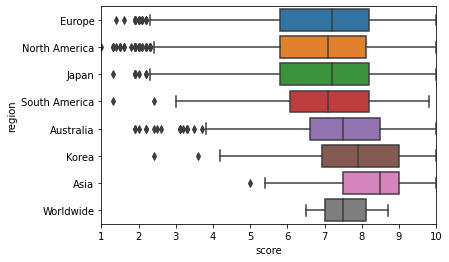

In [22]:
box_score_region = sb.boxplot(x="score", y="region", data=gamespot_final)
box_score_region.set_xlim(1, 10)

The ratings in the regions Europe, North America, Japan and South America are almost the same with slight differences. Most of the games in these regions are rated roughly between 6 and 8.

When looking at the regions Australia, Korea and Asia there is more of a difference. Compared to the first four regions games in those regions are rated higher with Asia rating games the highest out of all regions. Games that are released worldwide are mostly rated between 7 and 8.

There are also quite some outliers present with Australia and North America having most outliers. These are however not unrealistic and will not be excluded from the prediction because sometimes you just have a bad game and it'll be rated accordingly. Or people in that region just didn't like the game but I can't be sure on that.

# Prediction

Time to predict the rating of a game!

I will be using Multiple Regression for my prediction. I'm using multiple regression because I have more than one independent variables. Furthermore my predictor variable is score which is a continuous numerical variable and not a categorial variable meant to classify something. Using this variable in a Classification model would not be very useful. Multiple Regression is the correct model for this kind of prediction.

For this prediction I'll make a subset removing any NaN values that are present in the dataset and then turn the columns into dummy variables.

I'll be using all predictor variables in this prediction.

In [7]:
gamespot_final_01 = gamespot_final.dropna()

gamespot_final_01_dummies = pd.get_dummies(gamespot_final_01, 
                                           columns=["release_date", "region", "platform", 
                                                    "genres", "themes", "publishers"],
                                           drop_first=True)
gamespot_final_01_dummies.head()

,name,score,release_date_1994,release_date_1995,release_date_1996,release_date_1997,release_date_1998,release_date_1999,release_date_2000,release_date_2001,...,publishers_activision,publishers_capcom,publishers_electronic arts,publishers_konami,publishers_midway,publishers_nintendo,publishers_sega,publishers_square enix,publishers_thq,publishers_ubisoft
0,command & conquer,9.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,command & conquer,9.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,command & conquer,9.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,command & conquer,9.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,command & conquer,9.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


I will now split the data 70/30 into a train (70) and test (30) set. I will also use a random state so that the results can be reproduced.

In [70]:
x_01 = gamespot_final_01_dummies.loc[:, ~gamespot_final_01_dummies.columns.isin(["name", "score"])]
y_01 = gamespot_final_01_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_01, y_01, test_size = 0.3, random_state=1)

Now I will setup a LinearRegression model and fit it with the training data.

In [71]:
lm_01 = LinearRegression()
lm_01 = lm_01.fit(x_train, y_train)

Now to predict the score and then calculate the R^2 and the RMSE

In [72]:
y_test_p_01 = lm_01.predict(x_test)

r2_score(y_test, y_test_p_01)

-1.0098370226603202e+24

In [73]:
math.sqrt(mean_squared_error(y_test, y_test_p_01))

1460024440373.5183

I got an R^2 of negative value and an RMSE of 1.5. A negative R2 indicates that basically none of the ratings are impacted by any of the predictors, which is as bad as it can be. The RMSE is 1.5, the average error in predicting the rating. This means that every prediction is at least 1.5 points off. I consider this pretty high because ratings are based on a 1-10 scale and a difference in rating of 1.5 points means a lot.

Let's see if we can try and improve the model by doing multiple predictions with varying parameters.

I'll be using all variables except publishers in this prediction to see if this positively impacts the model. 70/30 train/test set and random state for reproduction

In [29]:
gamespot_final_02 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["publishers"])]

gamespot_final_02 = gamespot_final_02[gamespot_final_02["genres"].notna() 
                                      & gamespot_final_02["themes"].notna()]

gamespot_final_02_dummies = pd.get_dummies(gamespot_final_02, 
                                           columns=["release_date", "region", "platform", 
                                                    "genres", "themes"],
                                           drop_first=True)

In [30]:
x_02 = gamespot_final_02_dummies.loc[:, ~gamespot_final_02_dummies.columns.isin(["name", "score"])]
y_02 = gamespot_final_02_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_02, y_02, test_size = 0.3, random_state=2)

In [31]:
lm_02 = LinearRegression()
lm_02 = lm_02.fit(x_train, y_train)

In [32]:
y_test_p_02 = lm_02.predict(x_test)

r2_score(y_test, y_test_p_02)

-2.7542777415539913e+23

In [33]:
math.sqrt(mean_squared_error(y_test, y_test_p_02))

814649251290.401

This is much worse. Still none of the ratings are impacted by the predictors and the average error increased to 8.1 points. Looks like excluding the publishers was not the right way to go.

In this prediction I'll be using all variables except themes. I'm doing this for the same reason I exlcuded the publishers in the last model, to see if it has a positive effect on the model. 70/30 train/test set and random state for reproduction.

In [34]:
gamespot_final_03 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["themes"])]

gamespot_final_03 = gamespot_final_03[gamespot_final_03["genres"].notna() 
                                      & gamespot_final_03["publishers"].notna()]

gamespot_final_03_dummies = pd.get_dummies(gamespot_final_03, 
                                           columns=["release_date", "region", "platform", 
                                                    "genres", "publishers"],
                                           drop_first=True)

In [35]:
x_03 = gamespot_final_03_dummies.loc[:, ~gamespot_final_03_dummies.columns.isin(["name", "score"])]
y_03 = gamespot_final_03_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_03, y_03, test_size = 0.3, random_state=3)

In [36]:
lm_03 = LinearRegression()
lm_03 = lm_03.fit(x_train, y_train)

In [37]:
y_test_p_03 = lm_03.predict(x_test)

r2_score(y_test, y_test_p_03)

-5.0569257705004584e+23

In [38]:
math.sqrt(mean_squared_error(y_test, y_test_p_03))

1195634420084.7378

Th R2 is even worse than the second model. None of the ratings are impacted by the predictors and the average error remains high. Excluding the themes was not an improvement either. Hopefully the next model will be better.

I'll exlcude both publishers and themes this time. Hopefully it has a positive effect this time. 70/30 train/test set and random state for reproduction.

In [39]:
gamespot_final_04 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["themes", "publishers"])]

gamespot_final_04 = gamespot_final_04[gamespot_final_04["genres"].notna()]

gamespot_final_04_dummies = pd.get_dummies(gamespot_final_04, 
                                           columns=["release_date", "region", "platform", 
                                                    "genres"],
                                           drop_first=True)

In [40]:
x_04 = gamespot_final_04_dummies.loc[:, ~gamespot_final_04_dummies.columns.isin(["name", "score"])]
y_04 = gamespot_final_04_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_04, y_04, test_size = 0.3, random_state=4)

In [41]:
lm_04 = LinearRegression()
lm_04 = lm_04.fit(x_train, y_train)

In [42]:
y_test_p_04 = lm_04.predict(x_test)

r2_score(y_test, y_test_p_04)

-8.297981646259461e+22

In [43]:
math.sqrt(mean_squared_error(y_test, y_test_p_04))

468622775155.19885

Too bad. It did not improve on the previous models at all. removing both publishers and themes had no positive effect whatsoever. But I'm not done yet there are still a few parameters I wish to try out.

I will exclude release_date in the following prediction. 70/30 train/test set and random state for reproduction.

In [49]:
gamespot_final_05 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["release_date"])].dropna()

gamespot_final_05_dummies = pd.get_dummies(gamespot_final_05, 
                                           columns=["region", "platform", 
                                                    "genres", "themes", "publishers"],
                                           drop_first=True)

In [50]:
x_05 = gamespot_final_05_dummies.loc[:, ~gamespot_final_05_dummies.columns.isin(["name", "score"])]
y_05 = gamespot_final_05_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_05, y_05, test_size = 0.3, random_state=1)

In [51]:
lm_05 = LinearRegression()
lm_05 = lm_05.fit(x_train, y_train)

In [52]:
y_test_p_05 = lm_05.predict(x_test)

r2_score(y_test, y_test_p_05)

-1.8980163304457812e+24

In [53]:
math.sqrt(mean_squared_error(y_test, y_test_p_05))

2001633006367.9402

It's still bad but at least it's less bad than the previous models, being more closer to the first model. But the R2 is still lower and the average error is much higher. I will try to predict one more time with this type of model but I don't expect it to change much, but who knows.

In this prediction I will exclude platform. 70/30 train/test set and random state for reproduction.

In [88]:
gamespot_final_06 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["platform"])].dropna()

gamespot_final_06_dummies = pd.get_dummies(gamespot_final_06, 
                                           columns=["release_date", "region", 
                                                    "genres", "themes", "publishers"],
                                           drop_first=True)

In [89]:
x_06 = gamespot_final_06_dummies.loc[:, ~gamespot_final_06_dummies.columns.isin(["name", "score"])]
y_06 = gamespot_final_06_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_06, y_06, test_size = 0.3, random_state=6)

In [90]:
lm_06 = LinearRegression()
lm_06 = lm_06.fit(x_train, y_train)

In [91]:
y_test_p_06 = lm_06.predict(x_test)

r2_score(y_test, y_test_p_06)

0.2370740526197863

In [92]:
math.sqrt(mean_squared_error(y_test, y_test_p_06))

1.244977608569643

This is certainly an unexpected result! The R2 now says that 23% of  the ratings is impacted by the predictors. Which is very low, but significantly higher than any of the previous models! The RMSE is 1.2 which is one of the lowest average errors compared to the previous models. But it's still too high when you consider the 1-10 scale rating system Gamespot works with.

Let's try one more time with a different model. I will be using Polynomial Regression for this one. The reason I want to try Polynomial is because the data could be in a curved shape. That would mean the data is not linear and applying Linear Regression would not be the right option, instead Polynomial would be the right model to use for such a case.

I will only be using genres and a train/test set of 70/30 and will use a random state for reproduction.

In [25]:
gamespot_final_07 = gamespot_final.loc[:, ~gamespot_final.columns.isin(["release_date", "region", 
                                                    "themes", "publishers", "platform"])].dropna()

gamespot_final_07_dummies = pd.get_dummies(gamespot_final_07, 
                                           columns=["genres"], drop_first=True)

In [26]:
x_07 = gamespot_final_07_dummies.loc[:, ~gamespot_final_07_dummies.columns.isin(["name", "score"])]
y_07 = gamespot_final_07_dummies["score"]

x_train, x_test, y_train, y_test = train_test_split(x_07, y_07, test_size = 0.3, random_state=7)

In [27]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x_test)

poly.fit(x_poly, y_test)

lm_07 = LinearRegression()
lm_07.fit(x_poly, y_test)

LinearRegression()

In [28]:
y_test_p_07 = lm_07.predict(poly.fit_transform(x_test))

r2_score(y_test, y_test_p_07)

0.04616143785196958

In [29]:
math.sqrt(mean_squared_error(y_test, y_test_p_07))

1.6070333258356437

The R2 says that 4% of the ratings is impacted by the predictors. This is very low. The average error is 1.6 which I consider quite high. This is a bad model and using Polynomial instead of Linear Regression does not seem to make a big difference.

# Conclusion

After numerous predictions with differing parameters using Linear and Polynomial Regression, it is clear that these variables are unuseful when trying to predict the rating of a game. I would not recommend these models to be applied on a professional level.

This project however could be done again with a different/additional dataset where the sentiment of reviews can also be measured. I think that might yield more fruitful results than only checking on the genre of a game and who made the game.